# Toxic Spans Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from torchtext.data import Field
from torchtext.vocab import GloVe

from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer 
import spacy
import string
import ast
from termcolor import colored

from tqdm import trange, tqdm
from IPython.display import clear_output

from utils.processing import color_toxic_words, remove_symbols, completely_toxic, separate_words, get_index_toxic_words, f1, f1_scores
from utils.lstm import spacy_tokenizer, plot_loss_and_score, prepare_data, train_model

sns.set_style('darkgrid')
nlp = spacy.load('en_core_web_md')
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.current_device(), torch.cuda.get_device_name(0)

(0, 'GeForce RTX 2070')

In [2]:
# To plot using LaTeX, sometimes it gives trouble, in that case comment these two lines
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

- [Preprocesamiento](#Preprocesamiento)
- [LSTM](#LSTM)
  - [Embeddings](#Embeddings)
  - [Datasets y dataloaders](#Datasets)
  - [Training](#Training)
- [Evaluación](#Evaluación)

<a name="Preprocesamiento"></a>
## Preprocesamiento

El mayor problema son las publicaciones que están como [ ], así que tratamos 3 preprocesamientos distintos (aplicando siempre `remove_symbols`), para los score de Codalab usamos el **procesamiento 2**:

1. Dejando [ ] como están:
  - **best-model-try1.pt**, *train*=0.6198, *test*=0.6258.
2. Poner los posts con [ ] como completamente tóxicos:
  - **best-model-try2.pt**, *train*=0.6498 , *test*=0.6526 
3. Dropping [ ] del dataset de training:
  - **best-model-try3.pt**, *train*=0.7260, *test*=0.6459
  
Mejor score en Codalab: 0.6488.

In [3]:
train = pd.read_csv('../data/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../data/tsd_trial.csv', converters={'spans':ast.literal_eval})
evaluation = pd.read_csv('../data/tsd_test.csv')

In [4]:
train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [5]:
# Preprocesamiento-1: dejando [ ] como están

# # Quitamos símbolos
# indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
# train['spans_clean'] = indices_clean

# # Pasamos a minúscula
# train['text'] = train['text'].apply(lambda x:x.lower())

In [6]:
# Preprocesamiento-2: poner los posts con [ ] como completamente tóxicos

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

# Quitamos símbolos
indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

In [7]:
# Preprocesamiento-3: quitar las publicaciones [ ] del conjunto de entrenamiento

# indices = [i for i in train.index if len(train.loc[i]['spans']) == 0]
# train = train.drop(indices)

# # Quitamos símbolos
# indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
# train['spans_clean'] = indices_clean

# # Pasamos a minúscula
# train['text'] = train['text'].apply(lambda x:x.lower())

<a name="LSTM"></a>
## LSTM

Estamos basándonos en [Sequence models and LSTM networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html). 

<a name="Embeddings"></a>
### Cargar embeddings

Checar [Deep Learning For NLP with PyTorch and Torchtext](https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f).

In [8]:
# Descargar embeddings en caso de que no estén, puede tardar un rato
GloVe(name='twitter.27B', dim=200)

In [9]:
# Aquí había un problema, estábamos usando 2 tokenizadores diferentes para sacar los
# embeddings y para preprocesar el texto para entrenar. Pondré el de SpaCy como 
# tokenizador en común con el corpus de 'en_core_web_md'

text_field = Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_md',
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = train['text'].apply(lambda x: text_field.preprocess(x))
# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.twitter.27B.200d'
)
# get the vocab instance
vocab = text_field.vocab

/home/david/Documentos/Ciencia de Datos/3º semestre/PLN/Proyecto/SemEval2021/toxic-spans-venv/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
# El tokenizador hace bien su trabajo, los embeddings existen siempre y cuando la 
# palabra esté en el dataset de entrenamiento
vocab.lookup_indices(["f**k", 'dont', "do", "n't", '...', "are", 'a**hole', 'asshole'])

[4353, 12785, 29, 24, 57, 16, 7312, 980]

<a name="Datasets"></a>
### Datasets y dataloaders

In [11]:
train_data = prepare_data(train['spans_clean'], train['text'])
test_data = prepare_data(test['spans'], test['text'])

100%|██████████| 690/690 [00:04<00:00, 154.67it/s]


In [12]:
def prepare_sequence(seq):
    idxs = vocab.lookup_indices(seq)      # Si no está lo pone como 0
    return torch.tensor(idxs, dtype=torch.long, device=dev)

def prepare_sequence_tags(seq):
    tag_to_ix = {"non_toxic": 0, "toxic": 1} 
    idxs = [tag_to_ix[s] for s in seq]
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [13]:
class SpansDataset(Dataset):
    """Spans dataset."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        text = prepare_sequence(self.data[idx][0])
        spans = prepare_sequence_tags(self.data[idx][1])
        sample = {'tokenized' : self.data[idx][0], 'original_text' : self.data[idx][2], 'text': text, 'spans': spans, 'true_index' : self.data[idx][3]}

        return sample

In [14]:
train_size = len(train_data)
test_size = len(test_data)

train_ds = SpansDataset(train_data)
test_ds = SpansDataset(test_data)

# Having bigger batches WILL make training faster. However, big batches are more difficult  
# in RNNs in general due to variable sequence size, they need padding.
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True)

# Test is dev in reality
testloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [15]:
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

<a name="Training"></a>
### Training

In [16]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, stacked_layers, dropout_p, weight, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim         # Dimension del estado oculta en cada direccion de la LSTM
        self.stacked_layers = stacked_layers # Cuantas capas en la LSTM
        
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=stacked_layers,
                            dropout=dropout_p,
                            bidirectional=True)

        # Linear layers
        self.fc1 = nn.Linear(hidden_dim*2, 1) # 2 veces el tamaño de hidden_dim por ser bidireccional

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        output, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        x = torch.sigmoid(self.fc1(output.view(len(sentence), -1)))
        return x

In [17]:
def tagger_LSTM(text, threshold=0.5):
    """
    Hace el tagging con el modelo que entrenamos.
    """
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = spacy_tokenizer(text.lower()) # Parece funcionar mejor
    
    with torch.no_grad():
        inputs = prepare_sequence(words)
        tag_scores = model(inputs)
        
        tags = [1 if x > threshold else 0 for x in tag_scores]
        tagged_sentence = list(zip(words, tags))

    return tagged_sentence

In [18]:
# try2
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.2, vocab.vectors, HIDDEN_DIM, len(vocab.vectors))
model.to(torch.device(dev)) # Lo mueve a la GPU, en caso de que haya

# Antes eran 100
stop_after_best = 10
# Nombre del archivo de backup
savefile = 'models/best-model-try2.pt'

In [19]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTMTagger                               --
├─Embedding: 1-1                         (3,922,200)
├─LSTM: 1-2                              47,097,600
├─Linear: 1-3                            1,201
Total params: 51,021,001
Trainable params: 47,098,801
Non-trainable params: 3,922,200

Training on: GeForce RTX 2070
###############################################
Current epoch: 21
Last model save was in epoch 11
Stopping training in: 1 epochs.
###############################################
[Best iter] training F1 is: 0.6766653565858526
[Best iter] dev F1 is: 0.6017265203778007
###############################################
[Last iter] training F1 was: 0.7492784357238852
[Last iter] dev. F1 was: 0.5907988600623444
###############################################


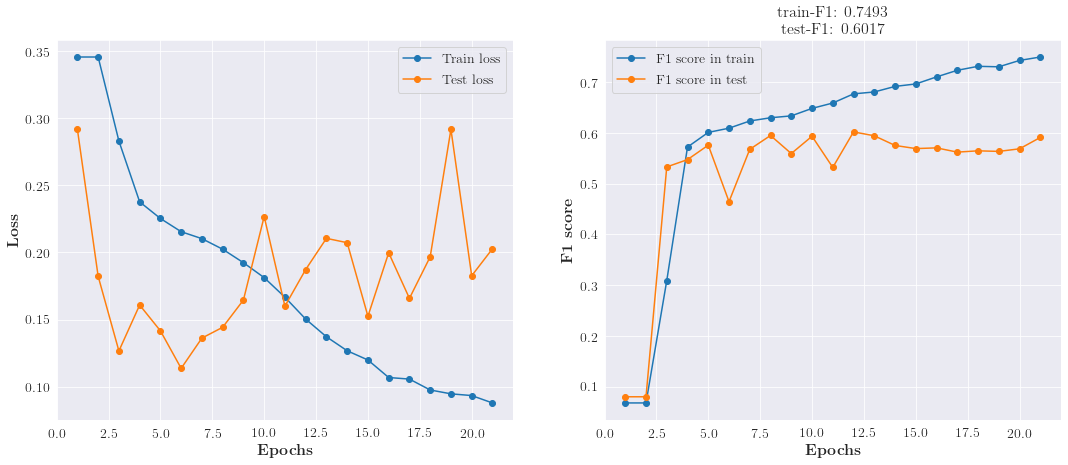

100%|██████████| 7939/7939 [06:52<00:00, 19.26it/s]


Starting evaluation for loss function.
Starting evaluation for dev F1
Finished Training


In [20]:
loss_per_epoch, training_loss, f1_scores_train, f1_scores_dev = train_model(model, trainloader, testloader, stop_after_best, savefile)

Para graficar la red ver [Visualize a net in PyTorch?](https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch)

<a name="Evaluación"></a>
## Evaluación

In [21]:
# model = torch.load('best-model-try2.pt')
# model.eval()

In [22]:
train = pd.read_csv('../data/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../data/tsd_trial.csv', converters={'spans':ast.literal_eval})
evaluation = pd.read_csv('../data/tsd_test.csv')

In [23]:
indices_test = []
for i, (gold_index, text) in enumerate(zip(test['spans'],test['text'])):
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_test.append(prediction_index)
    
    if i < 5:
        print(str(i) + colored(' Pred: ', color='cyan', attrs=['bold']) + 
           color_toxic_words(prediction_index, text))
        print(str(i) + colored(' Gold: ', color='yellow', attrs=['bold']) + 
              color_toxic_words(gold_index, text) + '\n'*2)

0 Pred: Because he's a moron and a bigot. It's not any more complicated than that.
0 Gold: Because he's a moron and a bigot. It's not any more complicated than that.


1 Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
1 Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


2 Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
2 Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


3 Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
3 Gold: Trump Claim

In [24]:
score_test = [f1(pred, gold) for pred,gold in zip(indices_test, test['spans'])]
print('F1 in test: {:.6f}'.format(np.mean(score_test)))

F1 in test: 0.550321
